<a href="https://colab.research.google.com/github/LostMa-ERC/simMAtree_workshop/blob/main/agent_based_models.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Manuscript Transmission as Speciation: Using Agent-Based Models and Bayesian Inference

### Digital Approaches to Pre-Modern Texts and Manuscripts (Workshop)

#### Jean-Baptiste Camps, Kelly Christensen, Ulysse Godreau, and Théo Moins

12 June 2025

## Agent based models for manuscript transmission

### Imports and setup

In [2]:
import os
!git clone https://github.com/LostMa-ERC/simMAtree_workshop.git
os.chdir('simMAtree_workshop')

Cloning into 'simMAtree_workshop'...
remote: Enumerating objects: 91, done.
remote: Counting objects: 100% (91/91), done.
remote: Compressing objects: 100% (85/85), done.
remote: Total 91 (delta 39), reused 11 (delta 4), pack-reused 0 (from 0)
Receiving objects: 100% (91/91), 2.30 MiB | 7.23 MiB/s, done.
Resolving deltas: 100% (39/39), done.


In [3]:
import simMAtree_workshop.birth_death_utils as u
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
from IPython.core.display import SVG, display
from tqdm.notebook import tqdm
from collections import Counter
import multiprocessing
import os
import pickle

### A simple stochastic model of manuscripts transmission: the Birth and Death Model

#### Simulating *arbres réels* and constructing stemmata

Let us first define the function that will simulate a single tree using the constant rate birth and death model

In [4]:
def generate_tree_bd(lda, mu, Nact, Ninact):
    """
    Generate a tree (arbre réel) according to birth death model.

    Parameters
    ----------
    lda : float
        birth rate of new node per node per iteration
    mu : float
        death rate of nodes per node per per iteration
    Nact : int
        number of iterations of the active reproduction phase
    Ninact : int
        number of iterations of the pure death phase (lda is set to 0)

    Returns
    -------
    G : nx.DiGraph()
        networkx graph object of the generated tree with following node attributes:
            'state' : boolean, True if node living at the end of simulation
            'birth_time' : int
            'death_time' : int

    """
    currentID = 0
    G = nx.DiGraph()
    G.add_node(currentID)
    living = {0:True}

    birth_time = {0:0}
    death_time = {}

    pop = 1
    prob_birth = lda
    prob_death = mu

    for t in range(Nact):
        for current_node in list(G.nodes()):
            r = np.random.rand()
            if r < prob_birth and living[current_node]:
                currentID += 1
                G.add_node(currentID)
                G.add_edge(current_node, currentID)
                living[currentID] = True
                pop += 1
                birth_time[currentID] = t
            if prob_birth < r and r < (prob_birth + prob_death) and living[current_node]:
                living[current_node] =  False
                pop -= 1
                death_time[current_node] = t
        if pop == 0:
            break

    for t in range(Ninact):
        for current_node in list(G.nodes()):
            r = np.random.rand()
            if r <  prob_death and living[current_node]:
                living[current_node] =  False
                pop -= 1
                death_time[current_node] = t + Nact
            if pop == 0:
                break

    nx.set_node_attributes(G, living, 'state')
    nx.set_node_attributes(G, birth_time, 'birth_time')
    nx.set_node_attributes(G, death_time, 'death_time')
    return G

We can now generate a simulated manuscript tradition and play around with parameters, display the corresponding tree of the full tradition as well as the corresponding *stemma codicum*

=== Full tradition ===


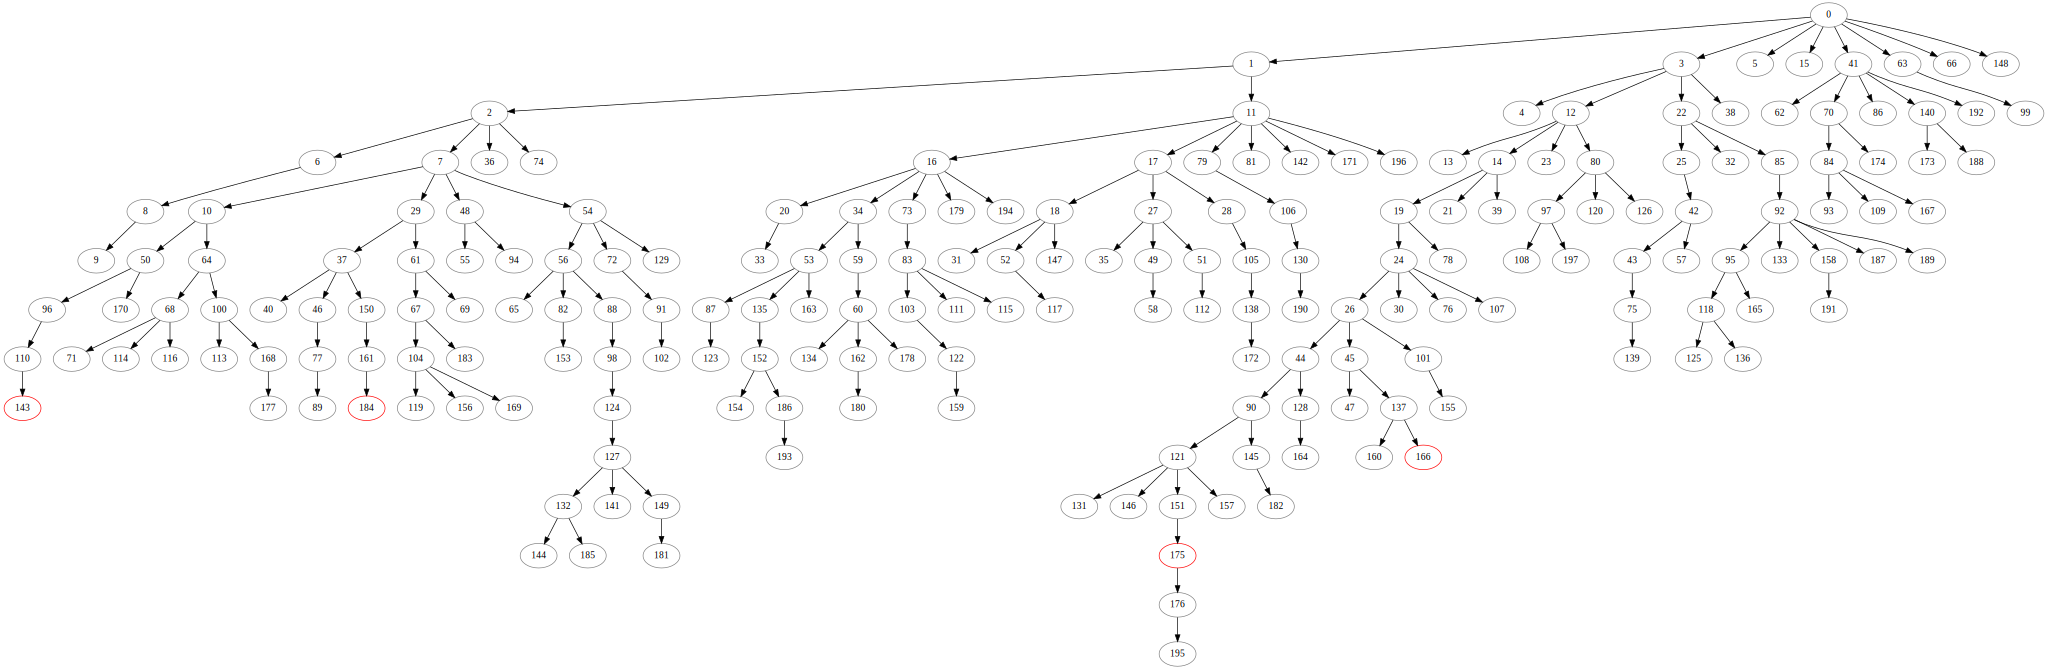

=== Stemma ===


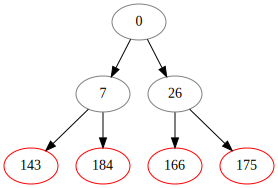

In [7]:
λ = 7.9*10**(-3)    # reproduction (=birth) rate
μ = 3.3*10**(-3)    # loss (=death) rate

active_phase_duration = 1000
decimation_phase_duration = 1000

tree = generate_tree_bd(λ, μ, active_phase_duration , decimation_phase_duration)    # generate a simulated full tradition
u.draw_tree(tree, 'arbre_reel')
if any(nx.get_node_attributes(tree,'state').values()):      # check if tradition has any surviving witness
    stemma = u.generate_stemma(tree)
    u.draw_tree(stemma, 'stemma')
    print('=== Full tradition ===')
    display(SVG('arbre_reel.svg'))
    print('=== Stemma ===')
    display(SVG('stemma.svg'))
else:
    print('=== Full tradition ===')
    display(SVG('arbre_reel.svg'))
    print('resulting tradition has no survivng witnesses...Try again !')

#### Simulating manuscript populations over parameter space

We know want to generate whole populations (*i.e.* many trees) for several values of the parameters λ and μ. we define a square region in the parameter space for ```lambda_min <= λ <= lambda_max``` and ```mu_min <= μ <= mu_max``` spanned by ```lambda_mesh * mu_mesh``` evenly spaced points. For each pair ```(λ,μ)```we genrate trad_nb different traditions, *i.e* artificial *texts*.

In [8]:
lambda_min=6.5*10**(-3)
lambda_max=8.5*10**(-3)
mu_min=3.5*10**(-3)
mu_max=4.5*10**(-3)

lambda_mesh=5
mu_mesh=5

Nact=1000
Ninact=1000

# parameters values
mu_range = np.linspace(mu_max, mu_min, mu_mesh)
lambda_range = np.linspace(lambda_min, lambda_max, lambda_mesh)

# parameter values as displayed in plots
lambda_labels = [r'%.1f'%n for n in (10**(3))*lambda_range]
mu_labels = [r'%.1f'%n for n in (10**(3))*mu_range]

trad_nb=200             # number of generated traditions (=trees)
path='bd_simulations'
output_format='serialized'

The whole set of simulations takes some minutes

In [10]:
if not os.path.exists(f'{path}'):
    os.mkdir(f'{path}')

progress = tqdm(total = mu_mesh * lambda_mesh * trad_nb)
for i in range(mu_mesh):
    for j in range(lambda_mesh):
        for k in range(trad_nb):
            l = lambda_range[j]
            m = mu_range[i]

            point_path = f'{path}/lambda={lambda_labels[j]}_mu={mu_labels[i]}'

            if not os.path.exists(point_path):
                os.mkdir(point_path)

            g = u.generate_tree(l, m, Nact, Ninact)

            if output_format == 'serialized':
                os.system(f'touch {point_path}/{k}')
                with open(f'{point_path}/{k}', 'wb') as f:
                    pickle.dump(g, f)

            if output_format == 'csv':
                csv_dump(g, f'{point_path}/{k}')

            progress.update(1)

  0%|          | 0/5000 [00:00<?, ?it/s]

#### Ploting phase diagrams

We may now compute and plot various statistics on simulated data:

- survival rate (proportion of trees with at least one surviving witness)
- median number of witnesses of a tradition
- stemmatic property such as the proportion of bifid stemmata

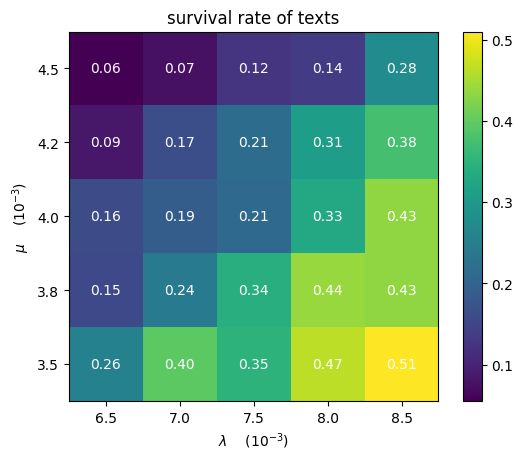

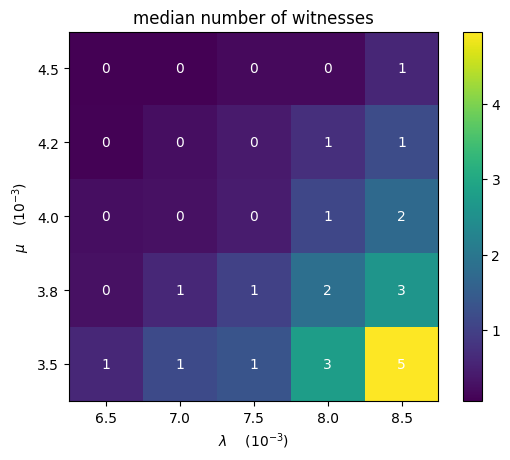

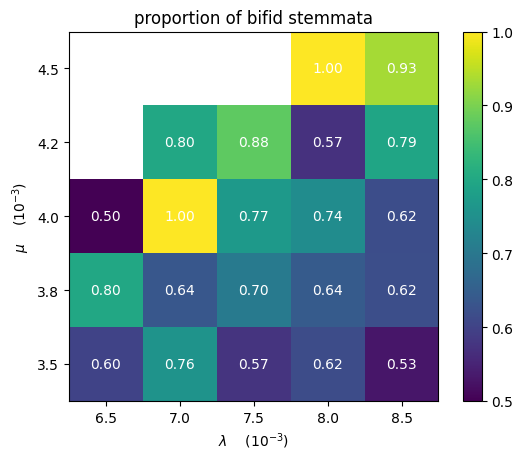

In [12]:
# path = 'bd_simulations_complete'

def survival_rate(trees):
    n_surv = 0
    for g in trees:
        if any(nx.get_node_attributes(g, 'state').values()):
            n_surv += 1
    return n_surv / len(trees)

def median_witness_number(trees):
    wit_nb = []
    for g in trees:
        wit_nb.append(u.witness_nb(g))
    return np.mean(wit_nb)

def bifidity_rate(trees):
    n_bifid = 0
    n_stemmata = 0
    for g in trees:
        if u.witness_nb(g) >= 3:
            n_stemmata += 1
            st = u.generate_stemma(g)
            rd = st.degree(u.root(st))
            if rd == 2:
                n_bifid += 1
    if n_stemmata > 0:
      return n_bifid / n_stemmata
    else:
      return float('nan')

u.plot_phase_diagram(path, lambda_labels, mu_labels, 200, survival_rate, 'survival rate of texts')
u.plot_phase_diagram(path, lambda_labels, mu_labels, 200, median_witness_number, 'median number of witnesses', prec=0)
u.plot_phase_diagram(path, lambda_labels, mu_labels, 200, bifidity_rate, 'proportion of bifid stemmata', prec=2)

#### Abundance data

For some specific values of the parameters λ and μ, we can now look at the distribution of the number of witnesses per texts (*abundance data*)

In [ ]:
λ = 7*10**(-3)
μ = 3*10**(-3)
Ta = 1000
Td = 1000

witness_numbers = []
for k in tqdm(range(1000)):
    g = generate_tree_bd(λ,μ,Ta,Td)
    witness_numbers.append(u.witness_nb(g))

x = Counter(witness_numbers).keys()
y = Counter(witness_numbers).values()
plt.semilogy(x,y,'+')

### A generalization of Birth-Death model: Yule Speciation model

In [ ]:
λ = 7.9*10**(-3)
μ = 3.3*10**(-3)
γ = .5*10**(-3)

active_phase_duration = 1000
decimation_phase_duration = 1000

tree = u.generate_yule_tree(λ,γ,μ, active_phase_duration, decimation_phase_duration)
if any(nx.get_node_attributes(tree,'state').values()):      # check if tradition has any surviving witness
    stemma = u.generate_stemma_yule(tree)
    u.draw_tree_yule(stemma, 'stemma_yule')
    print('=== Multi works stemma ===')
    display(SVG('stemma_yule.svg'))
else:
    print('resulting tradition has no survivng witnesses...Try again !')

#### Abundance data for Yule Model

In [ ]:
witnesses = u.generate_yule_pop(1*10**(-2), 12*10**(-3), 10**(-3), 3.3*10**(-3), 1000, 1000, 2)

In [ ]:
x = Counter(witnesses).keys()
y = Counter(witnesses).values()
plt.loglog(x,y,'+')